In [1]:
import pandas as pd
import numpy as np
import cooler
import cooltools
import matplotlib.pyplot as plt
from scipy.stats import kstest

In [3]:
genes_bed = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep="\t")
genes_bed.columns = ["chrom","start","end","gene_id","name","strand"]
longgenes_bed = genes_bed.query('end - start > 300000')

In [4]:
class insulation_gene:
    def __init__(self,name,chrom,start,end,matrix) -> None:
        self.name = name
        self.chrom = chrom
        self.start = start
        self.end = end
        self.matrix = matrix

# get insulation matrix for each gene
def get_insulation_matrix_for_celltype(insulation_table:pd.DataFrame,genes_bed:pd.DataFrame) -> list:
    res = []
    resolution = int(insulation_table.iloc[:1,].end - insulation_table.iloc[:1,].start)
    for gene_entry in genes_bed.itertuples():
        gene_name = gene_entry.name
        gene_chrom = gene_entry.chrom
        gene_start = gene_entry.start
        gene_end = gene_entry.end

        temp_start = gene_start // resolution * resolution 
        temp_end = gene_end // resolution * resolution + resolution
        columns = ["log2_insulation_score_" + str(reso) for reso in windows]
        gene_matrix = insulation_table.query('chrom == @gene_chrom & @temp_start <= start & @temp_end >= end')[columns].values
        gene_matrix = np.rot90(gene_matrix)

        res.append(insulation_gene(gene_name,gene_chrom,gene_start,gene_end,gene_matrix))

    return res

def multiple_testing_correction(pvalues, correction_type="FDR"):
    """
    Consistent with R - print
    multiple_testing_correction(np.array or list , correction_type from ["FDR","Bonferroni","Bonferroni-Holm"])
    reference: https://github.com/CoBiG2/cobig_misc_scripts/blob/master/FDR.py
    """
    from numpy import array, empty
    pvalues = array(pvalues)
    sample_size = pvalues.shape[0]
    qvalues = empty(sample_size)
    if correction_type == "Bonferroni":
        # Bonferroni correction
        qvalues = sample_size * pvalues
    elif correction_type == "Bonferroni-Holm":
        # Bonferroni-Holm correction
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        for rank, vals in enumerate(values):
            pvalue, i = vals
            qvalues[i] = (sample_size-rank) * pvalue
    elif correction_type == "FDR":
        # Benjamini-Hochberg, AKA - FDR test
        values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
        values.sort()
        values.reverse()
        new_values = []
        for i, vals in enumerate(values):
            rank = sample_size - i
            pvalue, index = vals
            new_values.append((sample_size/rank) * pvalue)
        for i in range(0, int(sample_size)-1):
            if new_values[i] < new_values[i+1]:
                new_values[i+1] = new_values[i]
        for i, vals in enumerate(values):
            pvalue, index = vals
            qvalues[index] = new_values[i]
    return qvalues

In [5]:
# load cooler
epi = cooler.Cooler("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/mcools/epiblast_and_PS.balanced.mcool::/resolutions/20000")
ex1 = cooler.Cooler("/shareb/zliu/analysis/hires_validation/BulkProcess/Ex1.3d20k.cool")
in1 = cooler.Cooler("/shareb/zliu/analysis/hires_validation/BulkProcess/In1.3d20k.cool")

In [9]:
# calculate insulation matrix
from itertools import repeat
windows = [100000*(i+1) for i in range(10)]
from multiprocessing import Pool
coolerList = [ex1,in1,epi]

insulations = []
def insulation_multi_wrapper(args):
    return cooltools.api.insulation.insulation(*args)
with Pool(10) as p:
    insulations = p.map(insulation_multi_wrapper,list(zip(coolerList,list(repeat(windows,len(coolerList))))))
            
ex1_insulation, in1_insulation, epi_insulation = insulations

In [10]:
#list of coord to bed file
def coord_to_bed(coord_list:list) -> pd.DataFrame:
    res = []
    for coord in coord_list:
        res.append([coord[0],int(coord[1]),int(coord[2]),coord[3]])
    return pd.DataFrame(res,columns=["chrom","start","end","name"])

coords_select = ["chr13:42500000-43500000-Phactr1",
                 "chr4:75800000-78300000-Ptprd"]
# spilt sep by : and -
import re
coords_select = [re.split("[:-]",i) for i in coords_select]

bed_select = coord_to_bed(coords_select)

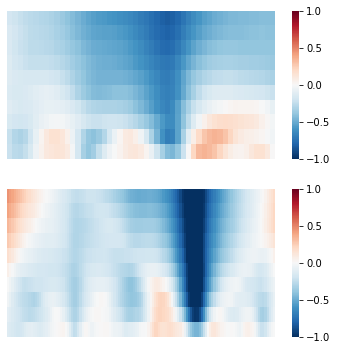

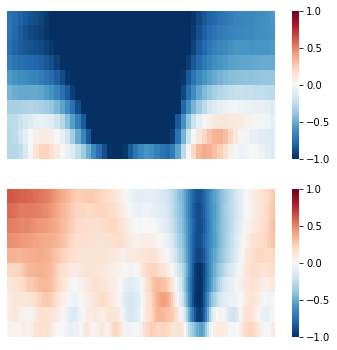

In [11]:
import seaborn as sns

ex1_select_matrix = get_insulation_matrix_for_celltype(ex1_insulation,bed_select)
in1_select_matrix = get_insulation_matrix_for_celltype(in1_insulation,bed_select)

f,ax = plt.subplots(len(ex1_select_matrix),1,figsize=(3*len(ex1_select_matrix),6))

for i in range(len(ax)):
    ax[i] = sns.heatmap(ex1_select_matrix[i].matrix,ax=ax[i],cmap="RdBu_r",vmin=-1,vmax=1)
    ax[i].axis('off')
plt.show()
f.savefig("example_insulation_plot/ex1_select_matrix.svg",dpi=300)



f,ax = plt.subplots(len(ex1_select_matrix),1,figsize=(3*len(ex1_select_matrix),6))

for i in range(len(ax)):
    ax[i] = sns.heatmap(in1_select_matrix[i].matrix,ax=ax[i],cmap="RdBu_r",vmin=-1,vmax=1)
    ax[i].axis('off')
plt.show()
f.savefig("example_insulation_plot/in1_select_matrix.svg",dpi=300)

In [ ]:
def get_insulation_matrix_for_celltype_multi_wrapper(args):
    return get_insulation_matrix_for_celltype(*args)
with Pool(10) as p:
    insulations_matrix = p.map(get_insulation_matrix_for_celltype_multi_wrapper,list(zip(insulations,list(repeat(longgenes_bed_flank,len(coolerList))))))


In [ ]:
ex1_insulation_matrix, in1_insulation_matrix, epi_insulation_matrix =insulations_matrix

In [ ]:
def calcMELSCORE(outpath,insumatrix_greater:list,insumatrix_smaller,longgenes_bed):
    MELSCORE =-np.log10(multiple_testing_correction([kstest(insumatrix_greater[i].matrix.reshape(1,-1)[0],insumatrix_smaller[i].matrix.reshape(1,-1)[0],alternative="greater").pvalue for i in range(len(longgenes_bed))]))
    DIFF = [np.nanmean(insumatrix_greater[i].matrix) - np.nanmean(insumatrix_smaller[i].matrix) for i in range(len(longgenes_bed))]
    longgenes_bed.loc[:,"Melscore"] = MELSCORE
    longgenes_bed.loc[:,"Diff"] = DIFF
    longgenes_bed.to_csv(outpath,index=False,sep="\t")

In [104]:
#output melscore matrix for intersing celltypes
#calcMELSCORE("ex1_epi.longgene.bed",ex1_insulation_matrix,epi_insulation_matrix,longgenes_bed)
#calcMELSCORE("in1_epi.longgene.bed",in1_insulation_matrix,epi_insulation_matrix,longgenes_bed)
calcMELSCORE("ex1_in1.longgene.bed",ex1_insulation_matrix,in1_insulation_matrix,longgenes_bed)
calcMELSCORE("in1_ex1.longgene.bed",in1_insulation_matrix,ex1_insulation_matrix,longgenes_bed)

/tmp/ipykernel_221118/3812210554.py:3: RuntimeWarning: Mean of empty slice
  DIFF = [np.nanmean(insumatrix_greater[i].matrix) - np.nanmean(insumatrix_smaller[i].matrix) for i in range(len(longgenes_bed))]
/tmp/ipykernel_221118/3812210554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longgenes_bed.loc[:,"Melscore"] = MELSCORE
/tmp/ipykernel_221118/3812210554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longgenes_bed.loc[:,"Diff"] = DIFF
/tmp/ipykernel_221118/3812210554.py:2: RuntimeWarning: divi

In [ ]:
id = 345
print(epi_insulation_matrix[id].name)
f,ax = plt.subplots(3,1,figsize=(12,6))

ax[0].imshow(ex1_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)
ax[1].imshow(in1_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)
ax[2].imshow(epi_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)

for i in range(len(ax)):
    ax[i].axis('off')
plt.show()

In [89]:
import cooltools.lib.plotting

In [90]:
print(ex1.matrix(balance=False).fetch("chr10:26,489,253-29,529,078").sum())
print(in1.matrix(balance=False).fetch("chr10:26,489,253-29,529,078").sum())

2024290
516740


/tmp/ipykernel_221118/3546477243.py:3: RuntimeWarning: divide by zero encountered in log2
  ax[0].imshow(np.log2(ex1.matrix(balance=True).fetch("chr10:27774819-28797397")),cmap="fall")#,vmin=0,vmax=20)
/tmp/ipykernel_221118/3546477243.py:4: RuntimeWarning: divide by zero encountered in log2
  ax[1].imshow(np.log2(in1.matrix(balance=True).fetch("chr10:27774819-28797397")),cmap="fall")


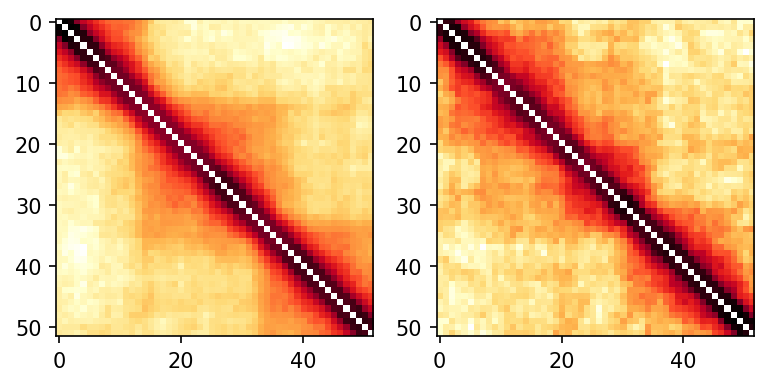

In [91]:
f,ax = plt.subplots(1,2,figsize=(6,12),dpi=150)

ax[0].imshow(np.log2(ex1.matrix(balance=True).fetch("chr10:27774819-28797397")),cmap="fall")#,vmin=0,vmax=20)
ax[1].imshow(np.log2(in1.matrix(balance=True).fetch("chr10:27774819-28797397")),cmap="fall")
#ax[2].imshow(epi_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)

Rbfox1


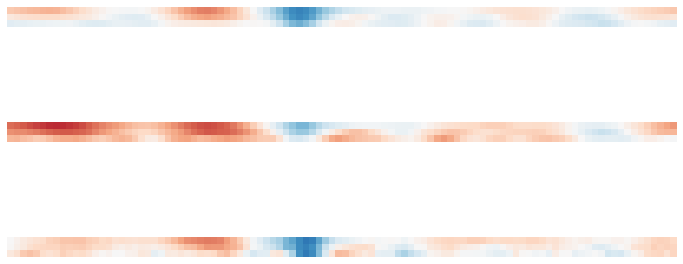

In [92]:
id = 505
print(epi_insulation_matrix[id].name)
f,ax = plt.subplots(3,1,figsize=(12,6))

ax[0].imshow(ex1_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)
ax[1].imshow(in1_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)
ax[2].imshow(epi_insulation_matrix[id].matrix,cmap="RdBu_r",vmin=-1,vmax=1)

for i in range(len(ax)):
    ax[i].axis('off')
plt.show()

In [52]:
pd.read_csv("./ex1_in1.longgene.bed",sep="\t").sort_values("Melscore",ascending=False).head(10)

,chrom,start,end,gene_id,name,strand,Melscore
139,chr4,75941237,78211961,ENSMUSG00000028399.18,Ptprd,-,68.705581
531,chr17,30459501,30923831,ENSMUSG00000118341.1,Gm50252,-,39.874668
461,chr14,38368951,39473088,ENSMUSG00000041014.17,Nrg3,-,36.220024
178,chr5,48389501,49524907,ENSMUSG00000029088.16,Kcnip4,-,33.235521
225,chr6,80018876,80810143,ENSMUSG00000052581.13,Lrrtm4,+,29.046052
363,chr10,108497649,109010982,ENSMUSG00000035864.14,Syt1,-,28.606930
239,chr6,110645580,111567230,ENSMUSG00000056755.13,Grm7,+,28.045163
54,chr2,6539693,7509563,ENSMUSG00000002107.18,Celf2,-,27.198266
31,chr1,115684755,116587323,ENSMUSG00000070695.4,Cntnap5a,+,26.416019
242,chr6,135713232,136173511,ENSMUSG00000030209.14,Grin2b,-,25.898459
